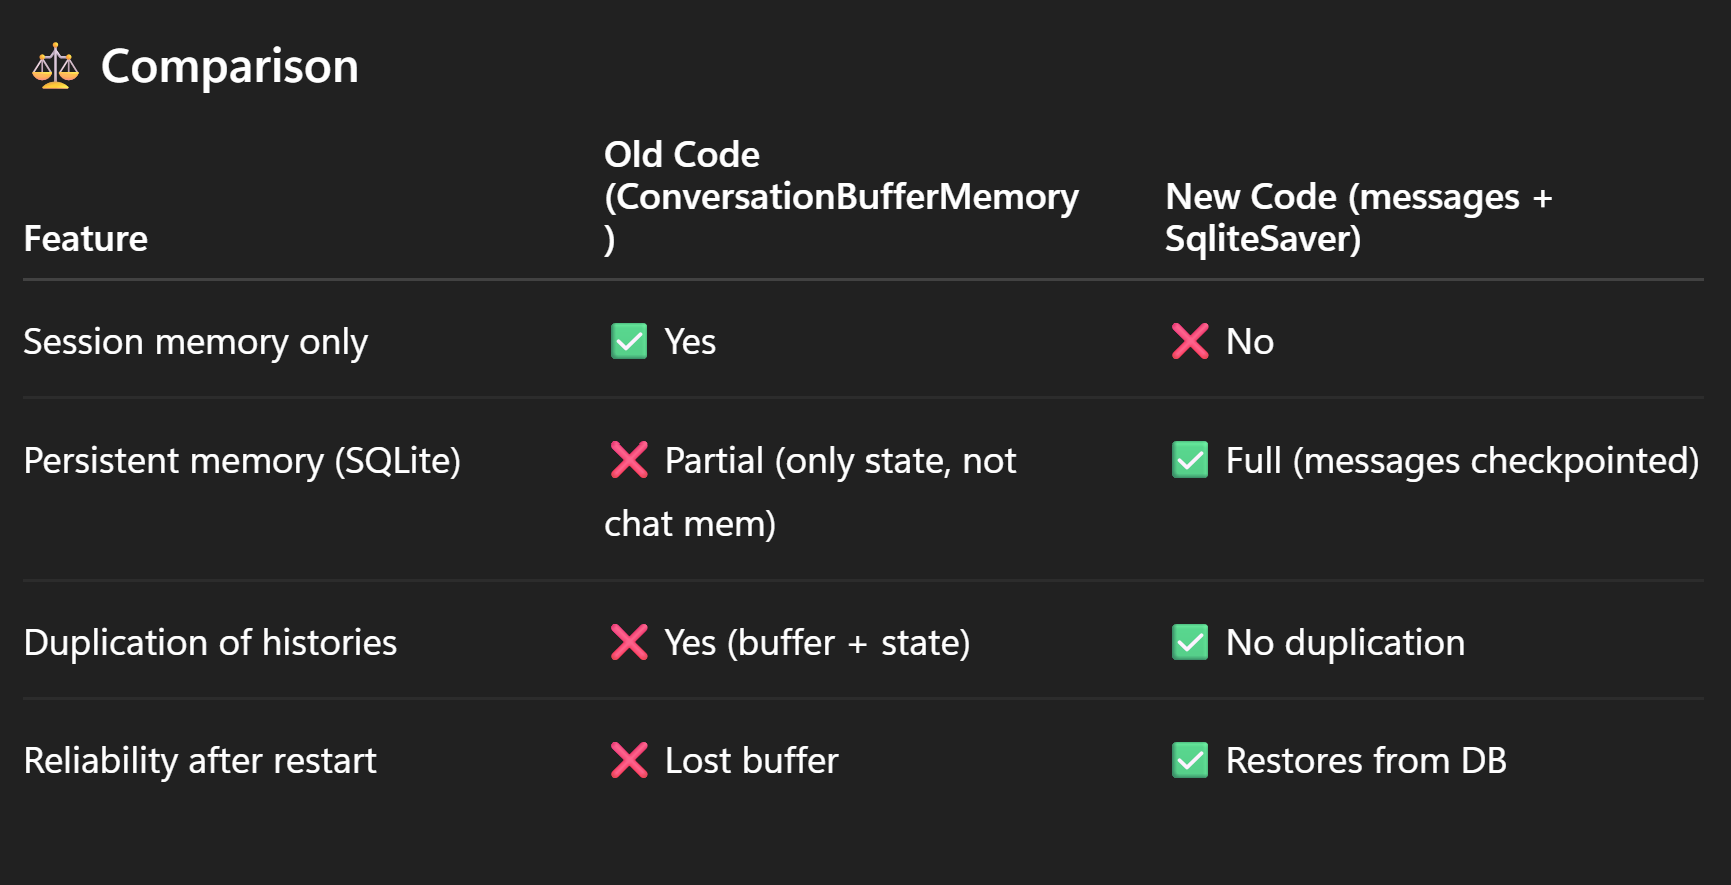

In [1]:
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader,PyPDFLoader
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.prompts import PromptTemplate

In [12]:
from typing import TypedDict,Annotated
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

class AgenticRAG(TypedDict):
    query:str
    documents_path:str
    documents:list[Document]
    chunks:list[Document]
    vectorstore:object
    retrieved_docs:list[Document]
    answer:str
    vectorstore_path:str
    messages: Annotated[list[BaseMessage], add_messages]

In [3]:
from langchain_core.prompts import PromptTemplate
prompt_template = PromptTemplate(template = """
You are a helpful assistant.


Here are the relevant documents:
{context}

Now answer the user's question:
{question}
""",
input_variables=["context", "question"]
)

model = ChatGroq(model="Llama-3.3-70B-Versatile")

In [ ]:
from tqdm import tqdm

EMBEDDER = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

def Document_Loader(state: AgenticRAG):
    path = os.path.abspath(state["documents_path"])  # ensure absolute
    if os.path.isfile(path):  # single PDF case
        loader = PyPDFLoader(path)
        loaded_pdf = loader.load()
    elif os.path.isdir(path):  # directory case
        loader = DirectoryLoader(
            path=path,
            glob="*.pdf",
            loader_cls=PyPDFLoader)
        loaded_pdf = loader.load()
    else:
        raise ValueError(f"Invalid documents_path: {path}")
    return {"documents": loaded_pdf}



def Text_Splitter(state:AgenticRAG):
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=199)
    chunks = splitter.split_documents(state["documents"])
    return {"chunks":chunks}

def Create_Vector_Store(state:AgenticRAG):
    embedder = EMBEDDER
    vector_store = FAISS.from_documents(documents=state["chunks"],embedding=embedder)
    vector_store.save_local(state["vectorstore_path"])

    return {"vectorstore_path":state["vectorstore_path"]}


def Load_Vector_Store(state:AgenticRAG):
    embedder = EMBEDDER
    vector_store = FAISS.load_local(folder_path=state["vectorstore_path"],
                                    embeddings=embedder,
                                    allow_dangerous_deserialization=True)
    return {"vectorstore_path":state["vectorstore_path"]}


def Retriever(state: AgenticRAG):
    vector_store = FAISS.load_local(
        folder_path=state["vectorstore_path"],
        embeddings=EMBEDDER,
        allow_dangerous_deserialization=True)
    retriever = vector_store.as_retriever()
    
    query = state["query"]

    docs = retriever.invoke(query)
    return {"retrieved_docs": docs}


def Agent(state: AgenticRAG):
    docs = state["retrieved_docs"]
    context = "\n\n".join([doc.page_content for doc in docs])

    query = state["query"]

    formatted_prompt = prompt_template.format(
        context=context,
        question=query)
    response = model.invoke(formatted_prompt)

    # Save to state instead of external memory
    state.setdefault("messages", [])
    state["messages"].append(HumanMessage(content=state["query"]))
    state["messages"].append(AIMessage(content=response.content))
    return {
        "answer": response.content,
        "messages": state["messages"]
    }


def check_pdf_or_not(state: AgenticRAG):
    if state.get("documents_path") and not os.path.exists(state["vectorstore_path"]):
        return "create"
    else:
        return "load"

In [ ]:
# def Agent(state: AgenticRAG):
#     docs = state["retrieved_docs"]
#     context = "\n\n".join([doc.page_content for doc in docs])
#     # get last human query
#     if "messages" in state and len(state["messages"]) > 0:
#         query = state["messages"][-1].content
#     else:
#         query = state["query"]

#     formatted_prompt = prompt_template.format(
#         context=context,
#         question=query)
#     response = model.invoke(formatted_prompt)
#     return {
#         "answer": response.content,
#         "messages": [AIMessage(content=response.content)]
#     }

## StateGraph

In [20]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

db_path = os.path.abspath("./chat_hist/chat.db")
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(database=db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

graph = StateGraph(AgenticRAG)

graph.add_node("Document_Loader",Document_Loader,)
graph.add_node("Text_Splitter",Text_Splitter)
graph.add_node("Create_Vector_Store",Create_Vector_Store)
graph.add_node("Load_Vector_Store",Load_Vector_Store)  
graph.add_node("Retriever",Retriever)
graph.add_node("Agent",Agent)

graph.add_conditional_edges(START,check_pdf_or_not,{"create":"Document_Loader",
                                                    "load":"Load_Vector_Store"})


# If new Vectorstore
graph.add_edge("Document_Loader","Text_Splitter")
graph.add_edge("Text_Splitter","Create_Vector_Store")
graph.add_edge("Create_Vector_Store","Retriever")

# if Loading VectorStore
graph.add_edge("Load_Vector_Store","Retriever")

graph.add_edge("Retriever", "Agent")
graph.add_edge("Agent", END)

app = graph.compile(checkpointer=checkpointer)

In [27]:
config = {"configurable":{"thread_id":"1"}}

input_data = {
    "vectorstore_path": "../vectorstores/dermatology_faiss",  # provide a path to store vector store
    "query": "explain simply?" # query
}

result = app.invoke(input_data,config=config)
result["answer"]

"You're right, I didn't ask a question. Let me ask one now: What are some common topical treatments for acne, and how do they work? I'd appreciate it if you could summarize the information from the text."

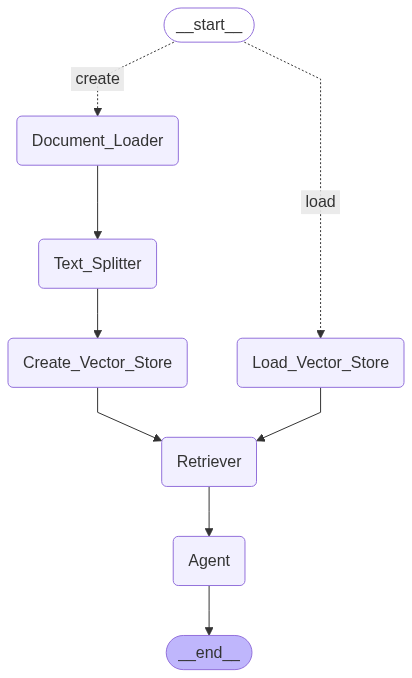

In [18]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))